In [2]:
import json
import glob
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# Load Data

In [3]:
def computeScore(runLog):
    return (runLog["WaypointsVisited"] - runLog["Steps"] / 1000.).mean()

def getMapName(path):
    rawName = os.path.splitext(os.path.basename(path))[0]
    # We now have ptsp_map$ID$, remove the ptsp_
    return rawName.split("_")[1]

# Gets the name of the algorithm and probability used from the filepath
def getFileData(filePath):
    fileName = os.path.splitext(os.path.basename(filePath))[0]
    algName, numWaypoints = fileName.split("_")
    return (algName, float(numWaypoints))

In [4]:
csvFiles = glob.glob("./*.csv")

algData = {}
for file in csvFiles:
    algName, numWaypoints = getFileData(file)
    if algName not in algData:
        algData[algName] = []
        
    algData[algName].append((file, numWaypoints))
    
# Sort the arrays in order of increasing waypoints
for alg in algData:
    algData[alg] = sorted(algData[alg], key=lambda x: x[1])
print(algData)

{'QD-MCTS-HP': [('.\\QD-MCTS-HP_0.00.csv', 0.0), ('.\\QD-MCTS-HP_0.01.csv', 0.01), ('.\\QD-MCTS-HP_0.05.csv', 0.05), ('.\\QD-MCTS-HP_0.10.csv', 0.1), ('.\\QD-MCTS-HP_0.20.csv', 0.2), ('.\\QD-MCTS-HP_0.50.csv', 0.5), ('.\\QD-MCTS-HP_0.80.csv', 0.8), ('.\\QD-MCTS-HP_0.90.csv', 0.9)], 'QD-MCTS': [('.\\QD-MCTS_0.00.csv', 0.0), ('.\\QD-MCTS_0.01.csv', 0.01), ('.\\QD-MCTS_0.05.csv', 0.05), ('.\\QD-MCTS_0.10.csv', 0.1), ('.\\QD-MCTS_0.20.csv', 0.2), ('.\\QD-MCTS_0.50.csv', 0.5), ('.\\QD-MCTS_0.80.csv', 0.8), ('.\\QD-MCTS_0.90.csv', 0.9)], 'VanillaMCTS': [('.\\VanillaMCTS_0.00.csv', 0.0), ('.\\VanillaMCTS_0.01.csv', 0.01), ('.\\VanillaMCTS_0.05.csv', 0.05), ('.\\VanillaMCTS_0.10.csv', 0.1), ('.\\VanillaMCTS_0.20.csv', 0.2), ('.\\VanillaMCTS_0.50.csv', 0.5), ('.\\VanillaMCTS_0.80.csv', 0.8), ('.\\VanillaMCTS_0.90.csv', 0.9)]}


# Load results without randomness
Since I did not run the experiment with a probability of 0, I have to use the results from the optimization experiment. They use exactly the same setup so it's easy to compare, I just have to find the best solution for each algorithm

In [5]:
# Align the logs for each run (*.csv) with the corresponding log containing the hyperparameters (optimizationLogs*.json)
def getLogPairs(alg):
    optimizationLogs = sorted(glob.glob(f"./optimizationResults/{alg}/optimizationLogs*.json"))
    runLogs = sorted(glob.glob(f"./optimizationResults/{alg}/*.csv"), key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))
    
    logPairs = []
    logNum = 0
    for log in optimizationLogs:
        for line in open(log).readlines():
            logPairs.append((pd.read_csv(runLogs[logNum], delimiter="\t"), json.loads(line)))
            logNum += 1
    return logPairs

In [6]:
algorithms = ["MS-MCTS", "QD-MCTS", "S-MCTS", "VanillaGA", "VanillaMCTS"]
    
# Read data
algLogDict = {}
for alg in algorithms:
    logPairs = getLogPairs(alg)

    # Safety Check that the alignment worked
    # We check that the scores logged in the optimization log match the score computed from the run log
    for runLog, optLog in logPairs:
        if abs(optLog["target"] - computeScore(runLog)) > 0.00001:
            print("Error scores do not align!")

    algLogDict[alg] = logPairs
    
# Find best run for each algorithm
bestRunsDict = {}
for alg in algorithms:
    logPairs = algLogDict[alg]
    # Find the run with the highest score
    bestRunLog, bestOptLog = max(logPairs, key=lambda pair: pair[1]["target"])
    print(f"Best score for {alg}: {bestOptLog['target']}")
    print(f"Best parameters for {alg}: {bestOptLog['params']}")
    bestRunsDict[f"{alg}\n{bestOptLog['target']:.2f}"] = bestRunLog

Best score for MS-MCTS: 4.53075
Best parameters for MS-MCTS: {'cellSize': 5.0281035350264, 'er': 9.359425031432846, 'rd': 22.141178093007678, 'steps': 559.4797441359474}
Best score for QD-MCTS: 7.003029999999998
Best parameters for QD-MCTS: {'highER': 19.564505347263143, 'lowER': 20.0, 'rd': 35.79060885649038, 'steps': 466.4566560402194}
Best score for S-MCTS: 5.063550000000001
Best parameters for S-MCTS: {'cellSize': 29.397034606386566, 'er': 13.81435314389922, 'rd': 39.716477585218485, 'steps': 513.1280037445927}
Best score for VanillaGA: 5.82191
Best parameters for VanillaGA: {'gl': 39.35328567880911, 'mr': 0.01, 'ps': 198.0172255671554}
Best score for VanillaMCTS: 6.8343
Best parameters for VanillaMCTS: {'er': 7.805778718651435, 'rd': 34.894420897604384}


# Plot how the probability affects the score

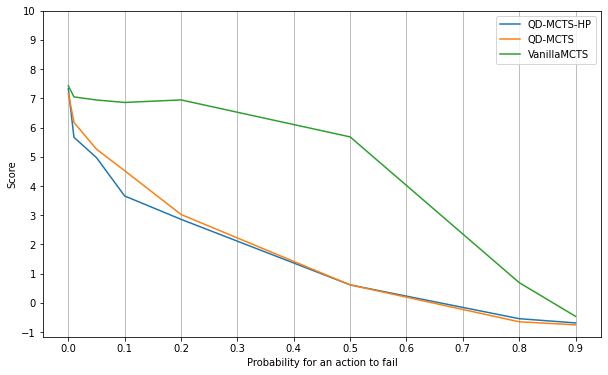

In [7]:
plt.figure(figsize=(10, 6))
for alg in algData:
    allProbabilities = []
    score = []
    for (fileName, probability) in algData[alg]:
        allProbabilities.append(probability)
        runData = pd.read_csv(fileName, delimiter="\t")
        score.append(computeScore(runData))
    plt.plot(allProbabilities, score, label=alg)
    
#plt.plot([0, 0.5, 1], [5, 5, 5], linestyle="--", label="QD-MCTS")
plt.grid(axis="x")
plt.xticks(np.linspace(0, 0.9, 10))
plt.yticks([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.xlabel("Probability for an action to fail")
plt.ylabel("Score")
plt.legend()
plt.savefig("stochasticEnvResults.png", bbox_inches='tight')

# Plot how the number of waypoints affects the score per map

In [8]:
mapData = {}
for alg in algData:
    scorePerMap = {}
    for (fileName, probability) in algData[alg]:
        runData = pd.read_csv(fileName, delimiter="\t")
        runData["MapName"] = [getMapName(name) for name in runData["MapName"]]
        
        for mapName, df in runData.groupby("MapName"):
            if mapName not in scorePerMap:
                scorePerMap[mapName] = []
            scorePerMap[mapName].append(computeScore(df))
            
    mapData[alg] = scorePerMap

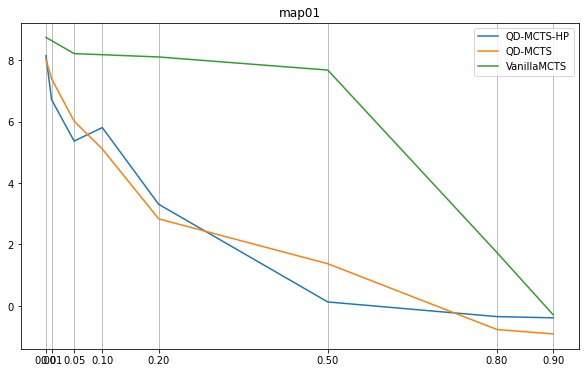

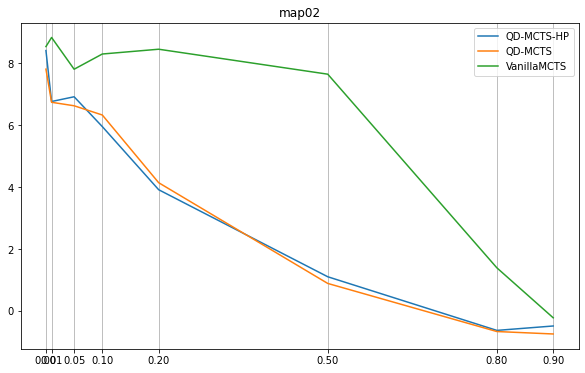

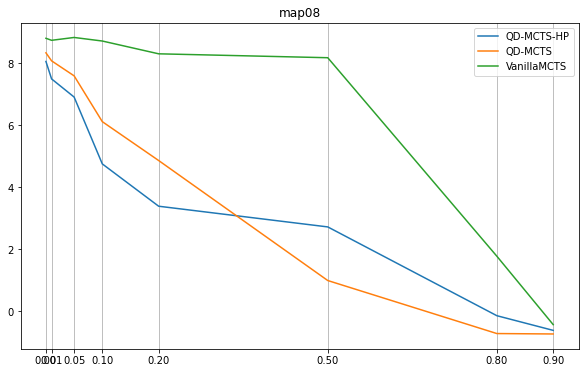

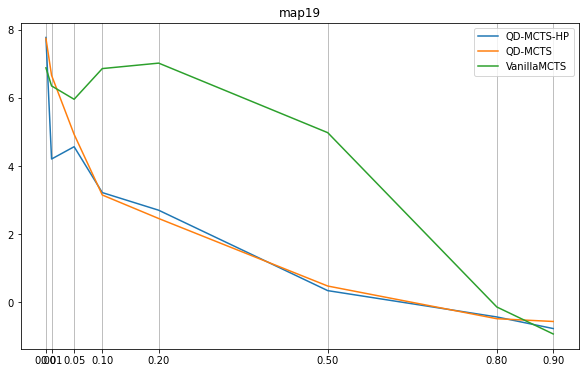

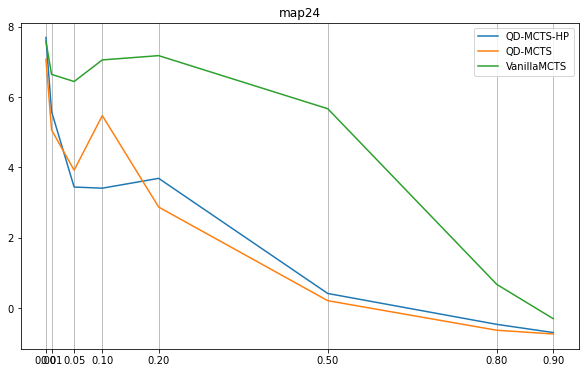

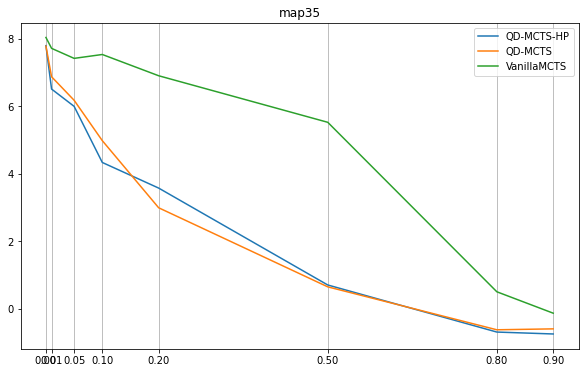

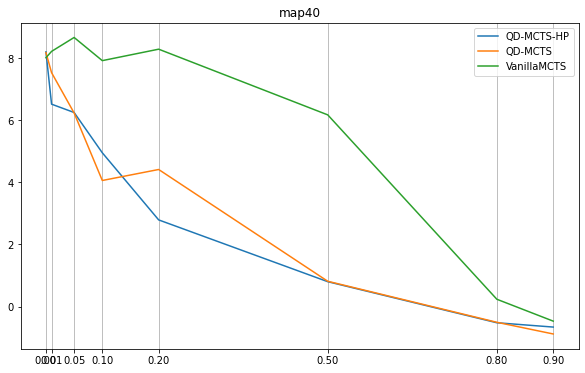

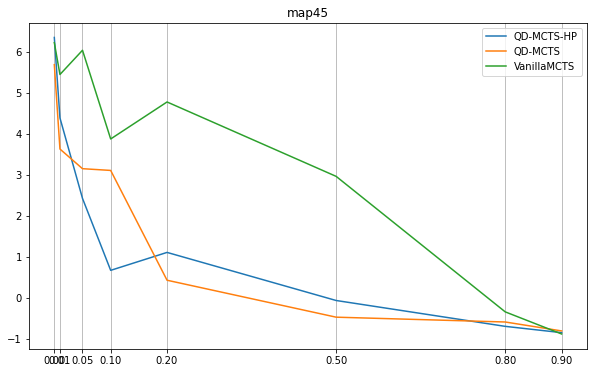

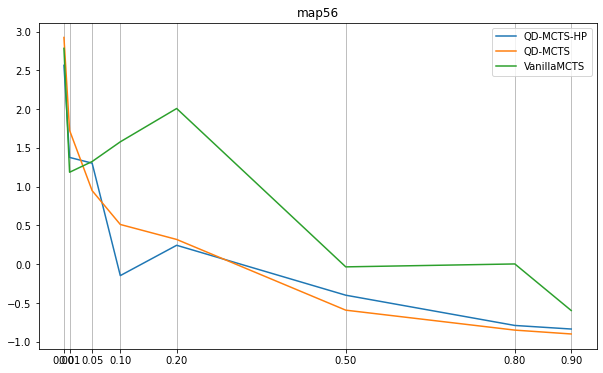

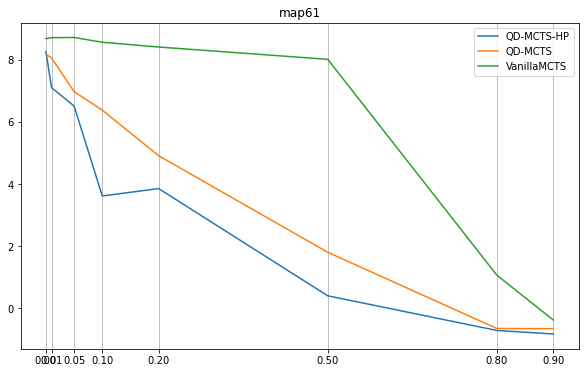

In [9]:
maps = [mapName for mapName in mapData["QD-MCTS"]]
for mapName in maps:
    plt.figure(figsize=(10, 6))
    plt.title(mapName)
    
    for alg in mapData:
        allProbabilities = [probability for (_, probability) in algData[alg]]
        plt.plot(allProbabilities, mapData[alg][mapName], label=alg)
    plt.grid(axis="x")
    plt.xticks(allProbabilities)
    plt.legend()
    plt.show()